In [33]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import mayavi.mlab
import laspy as lp
import cv2 as cv
from PIL import Image

In [34]:
# Load binary point cloud
bin_pcd = np.fromfile("/home/sourish-wicon-lab/Documents/WSN/data_road_velodyne/testing/velodyne/um_000001.bin", dtype=np.float32)

In [35]:
# Reshape and drop reflection values
points = bin_pcd.reshape((-1, 4))[:, 0:3]



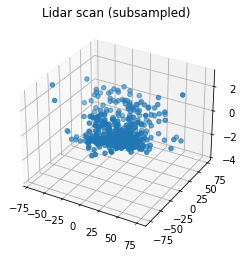

In [36]:
from mpl_toolkits.mplot3d import Axes3D
    
skip = 100 # plot one in every `skip` points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
velo_range = range(0, points.shape[0], skip) # skip points to prevent crash
ax.scatter(points[velo_range, 0],   # x
                points[velo_range, 1],   # y
                points[velo_range, 2],   # z
                #c=points[velo_range, 3], # reflectance
                cmap='gray')
ax.set_title('Lidar scan (subsampled)')
plt.show()

In [37]:
from scipy import signal

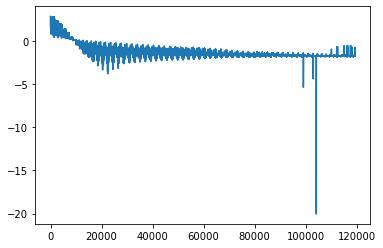

In [38]:
#Lidar Data
X = points[:,0]
Y = points[:,1]
Z = points[:,2]
plt.plot(Z)

In [39]:

# Specifications of Filter
  
 # sampling frequency
f_sample = 40 
  
# pass band frequency
f_pass = 4 
  
# stop band frequency
f_stop = 10  
  
# pass band ripple
fs = 0.1
  
# pass band freq in radian
wp = f_pass/(f_sample/2)  
  
# stop band freq in radian
ws = f_stop/(f_sample/2) 
  
# Sampling Time
Td = 1  
  
 # pass band ripple
g_pass = 0.5 
  
# stop band attenuation
g_stop = 40  

In [40]:

# Conversion to prewrapped analog frequency
omega_p = (2/Td)*np.tan(wp/2)
omega_s = (2/Td)*np.tan(ws/2)
  
  
# Design of Filter using signal.buttord function
N, Wn = signal.buttord(omega_p, omega_s, g_pass, g_stop, analog=True)
  
  
# Printing the values of order & cut-off frequency!
print("Order of the Filter=", N)  # N is the order
# Wn is the cut-off freq of the filter
print("Cut-off frequency= {:.3f} rad/s ".format(Wn))
  
  
# Conversion in Z-domain
  
# b is the numerator of the filter & a is the denominator
b, a = signal.butter(N, Wn, 'low', True)
z, p = signal.bilinear(b, a, fs)
# w is the freq in z-domain & h is the magnitude in z-domain
w, h = signal.freqz(z, p, 512)

Order of the Filter= 7
Cut-off frequency= 0.233 rad/s 


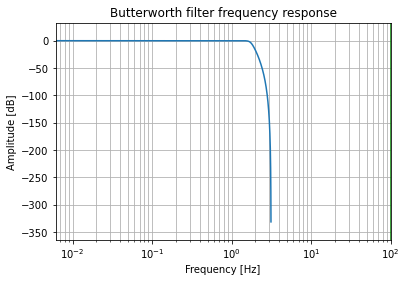

In [41]:

# Magnitude Response
plt.semilogx(w, 20*np.log10(abs(h)))
plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green')
plt.show()

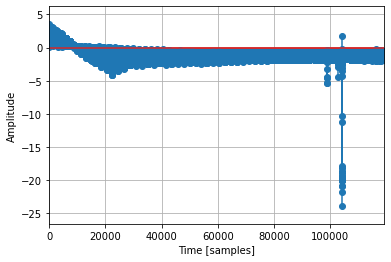

In [42]:
c, d = signal.butter(N, 0.5)
response = signal.lfilter(c, d, Z)
  
plt.stem(np.arange(0, len(Z)), Z, use_line_collection=True)
plt.stem(np.arange(0, len(Z)), response, use_line_collection=True)
plt.margins(0, 0.1)
  
plt.xlabel('Time [samples]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

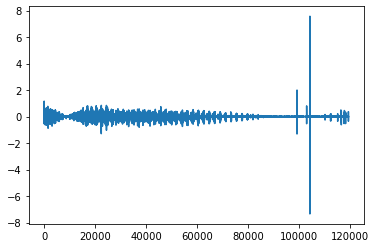

In [74]:
op_diff = np.gradient(response)
plt.plot(op_diff)  

In [75]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

In [76]:
weights = np.ones_like(Z)

In [77]:
op_ave, std = weighted_avg_and_std(Z, weights)

In [66]:
print(op_ave,std)

-1.329149 0.8222579


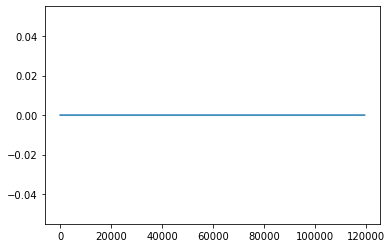

In [78]:
for i in range(len(op_diff)):
    if np.abs(op_diff[i])>std:
        op_diff[i]=0
    else:
        continue
plt.plot(op_diff)

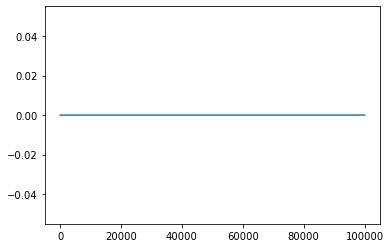

In [70]:
road = op_diff[10000:110000]
Z_op = Z[10000:110000]
plt.plot(Z_op)